In [1]:
#System imports
import math, time

import matplotlib.pyplot as plt

#Helper imports
import numpy as np
import cv2

#Nice printout imports
from termcolor import colored

#TensorFlow
import tensorflow as tf
import keras
from keras import layers

#Kaggle
import kagglehub

#Pandas
import pandas as pd

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.set_visible_devices([], 'GPU')

2025-02-03 19:40:56.073135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738608056.089514    3187 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738608056.094587    3187 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 19:40:56.111906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


W0000 00:00:1738608057.759745    3187 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.2. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [2]:
file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Wojtek.gzip'
df_W = pd.read_parquet(file_path)
df_W.drop(index=0, inplace=True)

file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_Artur.gzip'
df_A = pd.read_parquet(file_path)
df_A.drop(index=0, inplace=True)

features_W = np.asarray(df_W.drop(columns=['label']))
features_A = np.asarray(df_A.drop(columns=['label']))

In [3]:
labels_A = np.full((len(features_A),1), 0.0)
labels_W = np.full((len(features_W),1), 1.0)

labels = np.concatenate( (labels_A, labels_W) )
features = np.concatenate( (features_A, features_W) )

model = keras.Sequential(
    [
        layers.Dense(features.shape[1], activation="relu"),
        layers.Dense(features.shape[1]//2, activation="relu"),
        layers.Dense(features.shape[1]//4, activation="relu"),
        layers.Dense(features.shape[1]//8, activation="relu"),
        layers.Dense(1, activation="linear"),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)
model(features[0:1,:])
model.summary()

history = model.fit(
    features,
    labels,
    batch_size=128,
    epochs=10,
    shuffle=True
)
model.save(filepath="./model_A_vs_W.keras")

feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=[model.layers[-2].output],
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 1280)              │     1,639,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 640)               │       819,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 320)               │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 160)               │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 1)                 │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,716,161 (10.36 MB)

 Trainable params: 2,716,161 (10.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1738608060.311147    3267 service.cc:148] XLA service 0x79cae8020da0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738608060.311819    3267 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-03 19:41:00.562864: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738608061.675785    3267 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.9291 - loss: 0.1571
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.9999 - loss: 9.1648e-04
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.9990 - loss: 0.0032    
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.9991 - loss: 0.0015    
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 1.0000 - loss: 6.5997e-06
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 1.0000 - loss: 1.1497e-06
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 1.0000 - loss: 1.1474e-06
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 1.0000 - loss: 1.3950e-06
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 1.0000 - loss: 1.0125e-06
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 1.0000 - loss: 1.6231e-06


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3003, 1280))
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1500, 1280))
  warnings.warn(msg)


A width: 6.8512125
W width: 2.8413923
A-W distance: 6.68498


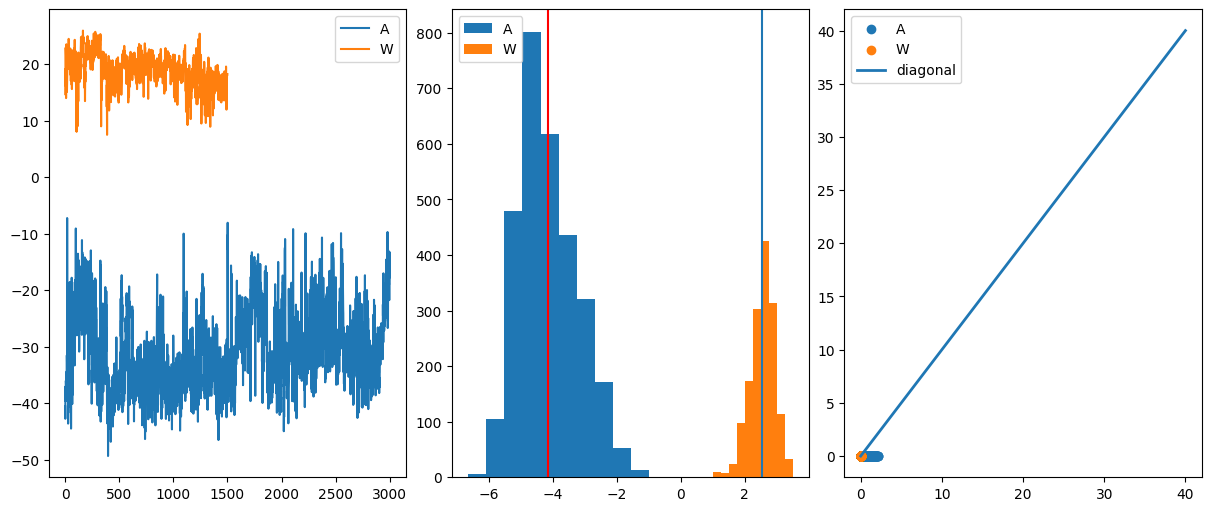

In [4]:
response_A = model.predict(features_A)
response_W = model.predict(features_W)

features_2D_A = feature_extractor(features_A)[:,-2:]
features_2D_W = feature_extractor(features_W)[:,-2:]

fig, axes = plt.subplots(1,3,layout='constrained', figsize = (12,5))

axes[0].plot(response_A, label="A")
axes[0].plot(response_W, label="W")
axes[0].legend();

sigma_A = response_A.std()
sigma_W = response_W.std()
sigma = np.sqrt(sigma_A**2 + sigma_W**2)
distance = np.mean(response_A/sigma) - np.mean(response_W/sigma)
axes[1].hist(response_A/sigma, label="A")
axes[1].hist(response_W/sigma, label="W")
axes[1].axvline(x=np.mean(response_A/sigma),color="red")
axes[1].axvline(x=np.mean(response_W/sigma))
axes[1].legend();
print(colored("A width:","blue"),sigma_A)
print(colored("W width:","blue"),sigma_W)
print(colored("A-W distance:","blue"),np.abs(distance))

axes[2].scatter(features_2D_A[:,0], features_2D_A[:,1], label="A")
axes[2].scatter(features_2D_W[:,0], features_2D_W[:,1], label="W")
axes[2].plot([0,40], [0,40], lw=2, label="diagonal")
axes[2].legend();

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4507, 1280))
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1500, 1280))
  warnings.warn(msg)


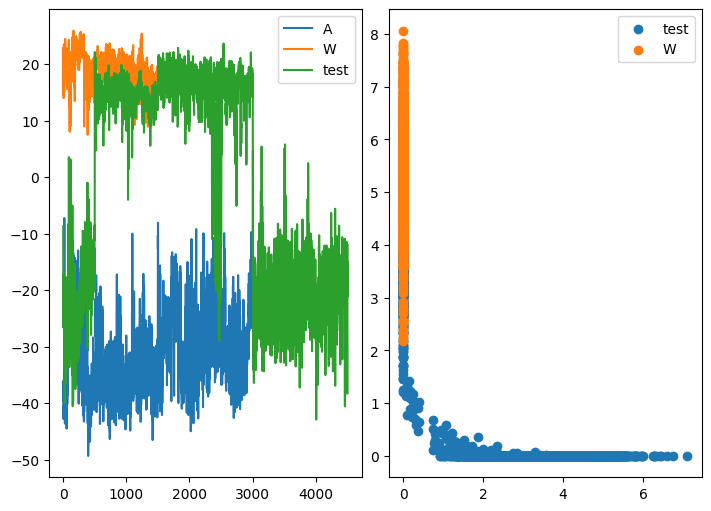

In [5]:
file_path = '/home/akalinow/scratch/RPi/FaceFollow/df.parquet_test.gzip'
df_test = pd.read_parquet(file_path)
df_test.drop(index=0, inplace=True)
features_test = np.asarray(df_test.drop(columns=['label']))


model = keras.saving.load_model("model_A_vs_W.keras")

response_A = model.predict(features_A)
response_W = model.predict(features_W)
response_test = model.predict(features_test)

features_2D_test = feature_extractor(features_test)
features_2D_W = feature_extractor(features_W)

fig, axes = plt.subplots(1,2,layout='constrained', figsize = (7,5))

axes[0].plot(response_A, label="A")
axes[0].plot(response_W, label="W")
axes[0].plot(response_test, label="test")
axes[0].legend();

axes[1].scatter(features_2D_test[:,0], features_2D_test[:,1], label="test")
axes[1].scatter(features_2D_W[:,0], features_2D_W[:,1], label="W")
axes[1].legend();